# Motorcycle categories - reclassification

# Introduction

The goal of this mini-project is to find out whether it would be possible to classify motorcycles based on their technical specs and other attributes, and replace the commonly used categorization that is driven by marketing slogans.

Motorcycle manufacturers often stick a label on a new model to target a specific demographic or to take advantage of a trend, but these categories are often meaningless or are limited to aesthetics.
I believe that a more objective way of categorizing motorcycles could be implemented based on actual technical data reflecting the real-life capabilities of a motorcycle model. Although the implementation of such a classification system requires efforts far beyond the scope of this assignment, a preliminary feasibility study or proof of concept can be a good starting point.

One of the limiting factors is access to data, but for this project the data provided by manufacturers to the Federal Roads Office of Switzerland (FEDRO) should be enough, as it contains all the technical specifications required by law to introduce a new model to the Swiss market.

The data is available in multiple formats from FEDRO's OpenData portal: https://www.ivz-opendata.ch/opendata/

The data set we are using today will be the subset provided by the organization for motorcycles specifically. 

This notebook and a copy of the data is available on GitHub: https://github.com/szando/motorcycle-class

# Implementation plan

1. Exploratory Data Analysis 
2. Data pre-processing   
3. Feature selection
4. Dimensionality reduction
5. Hierarchical clustering
6. Classifier implementation

# Prepare the environment

I moved all the import statements here so if anything is missing, there is still time to install it before starting the analysis. 

In [60]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Exploratory Data Analysis

In [43]:
# Load the dataset
file_path = '../data/TG-Moto.txt'  # Replace with your file path
exp_df = pd.read_csv(file_path, delimiter='\t', encoding='windows-1252')

Get an idea of the data structure and features

In [44]:
basic_description = exp_df.describe(include='all')
column_names = exp_df.columns.tolist()
data_types = exp_df.dtypes

basic_description, column_names, data_types

(       Typengenehmigungsnummer  Typengenehmigung erteilt  \
 count                    10065              1.006500e+04   
 unique                   10065                       NaN   
 top                     6AA101                       NaN   
 freq                         1                       NaN   
 mean                       NaN              2.009123e+07   
 std                        NaN              7.266090e+05   
 min                        NaN              0.000000e+00   
 25%                        NaN              2.005092e+07   
 50%                        NaN              2.012052e+07   
 75%                        NaN              2.019012e+07   
 max                        NaN              2.024033e+07   
 
         gültig für Importdatum bis  Erweiterung TG vom:  \
 count                 1.006500e+04         1.006500e+04   
 unique                         NaN                  NaN   
 top                            NaN                  NaN   
 freq                     

There were many "Unnamed" columns. That is due to the fact that the same file structure is used for various vehicle types, but not all columns are relevant for all of the different types. (For example, the same database contains the registration details of trailers and of course the features of a trailer are not the same as that of a car or truck)
That is something we'll have to deal with during data preprocessing.

In [47]:
initial_column_count = exp_df.shape[1]
df_cleaned_blank = exp_df.dropna(axis=1, how='all')
columns_dropped_blank = initial_column_count - df_cleaned_blank.shape[1]
columns_dropped_blank, df_cleaned_blank.shape[1]

(107, 117)

Pandas is usually pretty good at guessing the data type of a column, but not always, so let's check how it got on this time.

In [48]:
basic_description = df_cleaned_blank.describe(include='all')
column_names = df_cleaned_blank.columns.tolist()
data_types = df_cleaned_blank.dtypes

numeric_fields = data_types[data_types.apply(lambda x: x in ['int64', 'float64'])].index.tolist()
text_fields = data_types[data_types == 'object'].index.tolist()
other_fields = data_types[~data_types.apply(lambda x: x in ['int64', 'float64', 'object'])].index.tolist()
issues = data_types.isnull().sum()

{
    "basic_description": basic_description,
    "column_names": column_names,
    "numeric_fields": numeric_fields,
    "text_fields": text_fields,
    "other_fields": other_fields,
    "issues_with_data_types": issues
}

{'basic_description':        Typengenehmigungsnummer  Typengenehmigung erteilt  \
 count                    10065              1.006500e+04   
 unique                   10065                       NaN   
 top                     6AA101                       NaN   
 freq                         1                       NaN   
 mean                       NaN              2.009123e+07   
 std                        NaN              7.266090e+05   
 min                        NaN              0.000000e+00   
 25%                        NaN              2.005092e+07   
 50%                        NaN              2.012052e+07   
 75%                        NaN              2.019012e+07   
 max                        NaN              2.024033e+07   
 
         gültig für Importdatum bis  Erweiterung TG vom:  \
 count                 1.006500e+04         1.006500e+04   
 unique                         NaN                  NaN   
 top                            NaN                  NaN   
 freq

Some columns - especially the 'Bemerkungen*' ones - contain spaces and so they appear to be non-null. That is how they escaped the blank column identification before.
That is something to be addressed.

In [50]:
non_space_values_all = df_cleaned_blank.map(lambda x: not str(x).isspace() and pd.notna(x)).sum()
threshold = 100  
columns_to_drop = non_space_values_all[non_space_values_all < threshold].index
df_final_cleaned = df_cleaned_blank.drop(columns=columns_to_drop)

len(columns_to_drop), df_final_cleaned.shape[1]

(1, 116)

These are important things to know and have a plan to address before moving on to the next step: data pre-processing.

# (Re)Load and Preprocess the Data

Now that we have a better understanding of the data set, let's transform it into something more suited for the task.
- Load the file with the correct encoding and delimiter
- Remove the blank columns
- Remove the sparsely populated columns
- Normalize numeric values
- Encode categorical values

## Removing unnecessary columns

These are the data cleaning steps we identified durin EDA. Now let's just apply them to the working data set.

In [52]:
file_path = '../data/TG-Moto.txt'
df = pd.read_csv(file_path, delimiter='\t', encoding='windows-1252')
# Blank columns identified
df_cleaned = df.dropna(axis=1, how='all')
# Columns with empty space as value must be removed too
non_space_values_all = df_cleaned.map(lambda x: not str(x).isspace() and pd.notna(x)).sum()
# Sparsely populated columns identified
threshold = 500  # Drop columns with fewer than 500 non-space values
columns_to_drop = non_space_values_all[non_space_values_all < threshold].index
# Drop the identified columns
df_final_cleaned = df_cleaned.drop(columns=columns_to_drop)

print(f"{len(columns_to_drop)} columns were removed, leaving us with {df_final_cleaned.shape[1]} features")



13 columns were removed, leaving us with 104 features


## Normalizing the data

In this section, we will: 
- Encode the categorical/non-numeric data using one-hot encoding
- Normalize the numeric values using Standard Scaler

In [53]:
scaler = StandardScaler()
numeric_columns = df_final_cleaned.select_dtypes(include=['int64', 'float64']).columns
df_final_cleaned[numeric_columns] = scaler.fit_transform(df_final_cleaned[numeric_columns])

non_numeric_columns = df_final_cleaned.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_final_cleaned, columns=non_numeric_columns, drop_first=True)

df_encoded.shape

(10065, 74685)

# Feature selection

The previous steps first reduced the number of features, then thanks to the one-hot encoding, increased it hundred-fold.
However, it was necessary to encode the categorical values, so that we can now use PCA to select the features we actually need for clustering.

From previous experience, I knew that so many features will trip up PCA, so ironically, we need to select features for feature selection.

In this section we will:
- Eliminate some of the numeric features using a variance threshold
- Run PCA on the remaining data to further reduce the number of features 


## Feature pre-selection 

With the dimension explosion caused by the one-hot encoding, PCA would fail to run. 

In [54]:
# Featur selection for feature selection
selector = VarianceThreshold(threshold=0.01)
df_reduced = selector.fit_transform(df_encoded)

## Feature selection (dimensionality reduction) using PCA



In [24]:
pca = PCA()
print(f"Current dimensions: {df_reduced.shape}")
pca.fit(df_reduced)
# Calculate the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
# Determine the number of components needed to explain 95% of the variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
pca = PCA(n_components=n_components_95)  # Adjust based on explained variance threshold
df_pca = pca.fit_transform(df_reduced)
print(f"Reduced dimensionality by {n_components_95} for a new shape: {df_pca.shape}")


Current dimensions: (10065, 297)
Reduced dimensionality by 79 for a new shape: (10065, 79)


# Hierarchical clustering

## Generating a Dendrogram

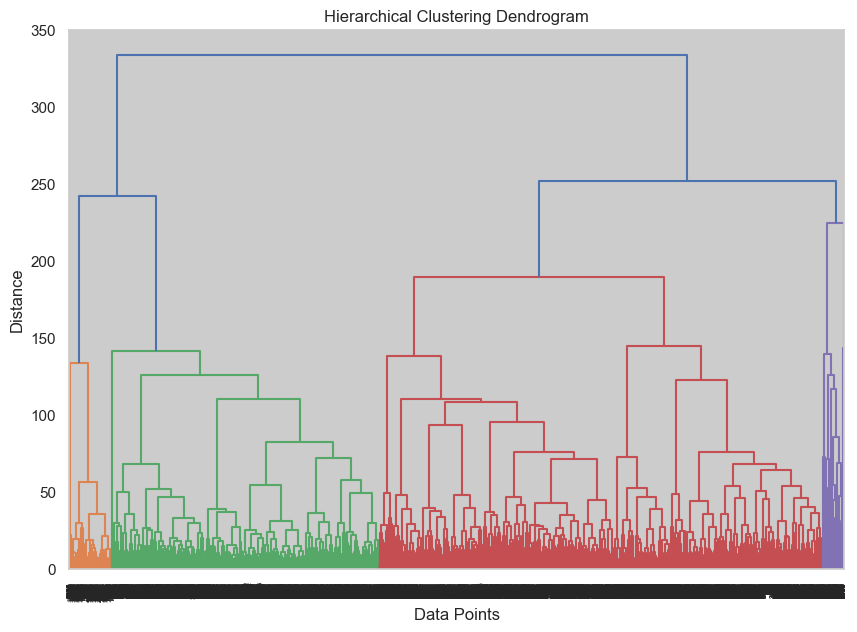

In [55]:
# Perform hierarchical clustering
linked = sch.linkage(df_pca, method='ward')
# linked = sch.linkage(pca.transform(df_reduced)[:, :n_components_95], method='ward')


# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

## Choosing a distance

Based on the dendrogram, we can choose a _distance_ as the threshold to limit the number of clusters.
Visual inspection of the dendrogram helped narrow down the range to somewhere between 100 and 150, but let's try to be more exact. 
To determine that horizontal cut-off line, let's try a few variations.

In [56]:
thresholds = [100, 110, 120, 130, 140, 150]
num_clusters = {}

for threshold in thresholds:
    clusters = sch.fcluster(linked, threshold, criterion='distance')
    num_clusters[threshold] = len(set(clusters))

num_clusters

{100: 19, 110: 18, 120: 15, 130: 12, 140: 9, 150: 6}

The choice is rather arbitrary, but let's pick 120, which should generate a reasonable number of clusters: 15.

## Clustering

We can go ahead with the clustering at this point.

In [57]:
clusters = sch.fcluster(linked, 120, criterion='distance')
df_final_cleaned['Cluster_Label'] = clusters

cluster_distribution = df_final_cleaned['Cluster_Label'].value_counts()

cluster_distribution

Cluster_Label
7     2870
5     2252
10    1783
4     1207
8      736
2      524
9      196
6      174
13     161
12      72
11      33
1       33
3       13
15       9
14       2
Name: count, dtype: int64

## Cluster characteristics


In [58]:
# Recalculate summary statistics for numeric features only
cluster_numeric_summary = df_final_cleaned.groupby('Cluster_Label').mean(numeric_only=True)

# For categorical features, let's calculate the mode only for columns with more than one unique value
cluster_categorical_summary = df_final_cleaned.groupby('Cluster_Label').agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)

# Display the summary statistics for numeric and categorical features
cluster_numeric_summary, cluster_categorical_summary.head()

(               Typengenehmigung erteilt  gültig für Importdatum bis  \
 Cluster_Label                                                         
 1                              0.020913                   -0.104416   
 2                              0.082011                   -1.432664   
 3                            -27.652043                   -1.347365   
 4                              0.038877                    0.073151   
 5                              0.012865                    0.126822   
 6                             -0.014889                    0.323150   
 7                             -0.010666                    0.332785   
 8                              0.079429                    0.116706   
 9                              0.033120                    0.274328   
 10                             0.120549                   -0.432198   
 11                            -0.098090                    0.445364   
 12                            -0.046604                    0.37

# Train a k-NN Classifier
We'll train a k-NN classifier using the cluster labels as the target.

In [61]:
X = df_final_cleaned.drop(columns=['Cluster_Label'])
y = df_final_cleaned['Cluster_Label']

knn = KNeighborsClassifier(n_neighbors=5)

X_encoded = pd.get_dummies(X, drop_first=True)

knn.fit(X_encoded, y)

y_pred = knn.predict(X_encoded)

classification_report_result = classification_report(y, y_pred, zero_division=1)
confusion_matrix_result = confusion_matrix(y, y_pred)

classification_report_result, confusion_matrix_result

('              precision    recall  f1-score   support\n\n           1       1.00      1.00      1.00        33\n           2       1.00      1.00      1.00       524\n           3       1.00      1.00      1.00        13\n           4       0.98      0.98      0.98      1207\n           5       1.00      1.00      1.00      2252\n           6       1.00      0.93      0.96       174\n           7       0.99      0.99      0.99      2870\n           8       1.00      1.00      1.00       736\n           9       0.99      0.95      0.97       196\n          10       0.99      0.99      0.99      1783\n          11       1.00      1.00      1.00        33\n          12       1.00      1.00      1.00        72\n          13       0.98      0.99      0.98       161\n          14       1.00      0.00      0.00         2\n          15       1.00      1.00      1.00         9\n\n    accuracy                           0.99     10065\n   macro avg       0.99      0.92      0.92     10065\nweig

## Validating the classifier

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
classification_report_test = classification_report(y_test, y_pred_test)
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

classification_report_test, confusion_matrix_test


('              precision    recall  f1-score   support\n\n           1       1.00      1.00      1.00        10\n           2       1.00      1.00      1.00       149\n           3       1.00      1.00      1.00         3\n           4       0.96      0.96      0.96       374\n           5       0.98      1.00      0.99       658\n           6       0.96      0.88      0.92        56\n           7       0.98      0.99      0.99       873\n           8       1.00      1.00      1.00       222\n           9       0.96      0.85      0.90        65\n          10       0.98      0.98      0.98       524\n          11       1.00      1.00      1.00        15\n          12       1.00      1.00      1.00        21\n          13       0.98      0.96      0.97        47\n          15       1.00      1.00      1.00         3\n\n    accuracy                           0.98      3020\n   macro avg       0.99      0.97      0.98      3020\nweighted avg       0.98      0.98      0.98      3020\n',
 

### Cross validation

In [63]:
cv_scores = cross_val_score(knn, X_encoded, y, cv=5)
cv_scores, cv_scores.mean()
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score*100:.1f}%")
    
print(f"\nMean accuracy across the folds is {cv_scores.mean()*100:.1f}%")


/home/sandor/PycharmProjects/shared_venvs/final_metamoto/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1: 92.8%
Fold 2: 89.8%
Fold 3: 91.9%
Fold 4: 95.2%
Fold 5: 93.5%

Mean accuracy across the folds is 92.6%


The classifier performs well overall, but there's some variability in accuracy between different folds. The slightly lower performance in one fold (Fold 2) could be due to the presence of clusters with very few data points, as indicated by the warning that some classes have very few members: `UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.`

### User validation

The whole point of having a classifier is allowing a user/developer/analyst to use it, so I thought it would be great to provide a user-friendly way to classify a motorcycle.


In [64]:
def predict_cluster_by_id(id_value, id_column, data, knn, full_data):
    """
    Predict the cluster label for records matching the given ID.
    
    Parameters:
    - id_value: The value of the ID to search for (e.g., '6AA101').
    - id_column: The column name where the ID is stored (e.g., 'Typengenehmigungsnummer').
    - data: The original DataFrame containing all records.
    - knn: The trained k-NN classifier.
    - full_data: The DataFrame containing the training data (encoded).
    
    Returns:
    - A dictionary where keys are the index of the matched records and values are the predicted cluster labels.
    """
    matching_records = data[data[id_column] == id_value]
    
    if matching_records.empty:
        return f"No records found with {id_column} = {id_value}"
    predictions = {}
    
    for index, record in matching_records.iterrows():
        record_df = pd.DataFrame([record])
        record_encoded = pd.get_dummies(record_df).reindex(columns=full_data.columns, fill_value=0)
        predicted_label = knn.predict(record_encoded)
        
        predictions[index] = predicted_label[0]    
    return predictions



Let's try an example. Of course the real use of it would be on brand new data, but it's not every day that a new motorcycle model goes through the process of being accepted into the Swiss vehicle market, so we'll have to settle for an existing model. I just picked one at random. (And by random I mean my own bike.)
  
The 'Typengenehmigungsnummer' is supposed to be unique, as it identifies a motorcycle model, but there are actually variants and duplicates due to administrative reasons and so on, which means that there might be multiple records found. In that case, we'll try to be user-friendly and return the label for all records. 

In [65]:
id_value = '6XA538'
id_column = 'Typengenehmigungsnummer' 
predictions = predict_cluster_by_id(id_value, id_column, df_cleaned, knn, X_encoded)


print("Predicted Cluster Labels for Matching Records:")
for index, cluster in predictions.items():
    print(f"Record Index {index}: Predicted Cluster Label = {cluster}")

Predicted Cluster Labels for Matching Records:
Record Index 8289: Predicted Cluster Label = 10


# Conclusion

In the end, we managed to build a classifier that is able to "categorize" motorcycles based on technical data and do it with relatively good accuracy.
 
However, its usefulness is severely limited:
- The categories are not explained, and they are probably not explainable
- Including all the data for each motorcycle model may have been a wrong choice, because the categories are now too broad.
- It could be improved by including more detailed data sets and motorcycle reviews describing the handling and other perceived characteristics from a human perspective    